# ML comparisons

In [32]:
import pandas as pd
from remseno import *

data_dir = '../data/to_publish/'

neon_gold_df = pd.read_csv(f'{data_dir}training_pixels_neon_validation_nn.csv')
tallo_training_df = pd.read_csv(f'{data_dir}Tallo_pixel_training_data.csv')
shared_species = list(set(neon_gold_df.species) & set(tallo_training_df.species))
print("Shared species:", shared_species)

Shared species: ['Acer saccharum', 'Pinus echinata', 'Pinus taeda', 'Ulmus americana', 'Quercus velutina', 'Picea abies', 'Juglans nigra', 'Pseudotsuga menziesii', 'Tilia americana', 'Pinus strobus', 'Quercus nigra']


In [33]:
import itertools
comb_2 = list(itertools.combinations(shared_species, 2))
comb_3 = list(itertools.combinations(shared_species, 3))
comb_4 = list(itertools.combinations(shared_species, 4))

In [34]:
comb_4

[('Acer saccharum', 'Pinus echinata', 'Pinus taeda', 'Ulmus americana'),
 ('Acer saccharum', 'Pinus echinata', 'Pinus taeda', 'Quercus velutina'),
 ('Acer saccharum', 'Pinus echinata', 'Pinus taeda', 'Picea abies'),
 ('Acer saccharum', 'Pinus echinata', 'Pinus taeda', 'Juglans nigra'),
 ('Acer saccharum', 'Pinus echinata', 'Pinus taeda', 'Pseudotsuga menziesii'),
 ('Acer saccharum', 'Pinus echinata', 'Pinus taeda', 'Tilia americana'),
 ('Acer saccharum', 'Pinus echinata', 'Pinus taeda', 'Pinus strobus'),
 ('Acer saccharum', 'Pinus echinata', 'Pinus taeda', 'Quercus nigra'),
 ('Acer saccharum', 'Pinus echinata', 'Ulmus americana', 'Quercus velutina'),
 ('Acer saccharum', 'Pinus echinata', 'Ulmus americana', 'Picea abies'),
 ('Acer saccharum', 'Pinus echinata', 'Ulmus americana', 'Juglans nigra'),
 ('Acer saccharum',
  'Pinus echinata',
  'Ulmus americana',
  'Pseudotsuga menziesii'),
 ('Acer saccharum', 'Pinus echinata', 'Ulmus americana', 'Tilia americana'),
 ('Acer saccharum', 'Pinus 

# Filter the datasets to only include the shared species

In [35]:
u = SciUtil()
shared_species = set(neon_gold_df.species) & set(tallo_training_df.species)
tallo_training_df = tallo_training_df[tallo_training_df.species.isin(shared_species)]
neon_gold_df = neon_gold_df[neon_gold_df.species.isin(shared_species)]

# Print the value counts of both
u.dp(['Tallo Training: '])
print(tallo_training_df.species.value_counts())

u.dp(['Neon Validation: '])
print(neon_gold_df.species.value_counts())

# Make a training sample that is a subsample with "even" classes
max_sample = 1000
train_df = pd.DataFrame()# Get a random sample which is even between each species

for species in set(tallo_training_df['species'].values):
    s_df = tallo_training_df[tallo_training_df['species'] == species]
    train_df = pd.concat([train_df, s_df.sample(min(1000, len(s_df)))])


--------------------------------------------------------------------------------
                               Tallo Training: 	                                
--------------------------------------------------------------------------------
species
Picea abies              46254
Juglans nigra            28699
Quercus nigra            28609
Pinus echinata           28561
Pinus strobus            28547
Acer saccharum           28473
Ulmus americana          28172
Tilia americana          28164
Pinus taeda              28160
Quercus velutina         28123
Pseudotsuga menziesii    25785
Name: count, dtype: int64
--------------------------------------------------------------------------------
                               Neon Validation: 	                               
--------------------------------------------------------------------------------
species
Pseudotsuga menziesii    650
Acer saccharum           337
Ulmus americana          230
Juglans nigra            174
Quercus nigra  

# Try different classififications using different models and number of class probelms


1. 2 class problem
2. 2 class imbalanced problem
3. 3 class problem
4. 4 class problem
5. All

In [24]:
sp_2 = ['Pseudotsuga menziesii', 'Acer saccharum']
sp_2_imb = ['Pseudotsuga menziesii', 'Quercus velutina']
sp_3 = ['Pseudotsuga menziesii', 'Acer saccharum', 'Ulmus americana']
sp_4 = ['Pseudotsuga menziesii', 'Acer saccharum', 'Ulmus americana', 'Juglans nigra']


In [42]:
from remseno import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score, balanced_accuracy_score, class_likelihood_ratios, f1_score, precision_score, roc_auc_score, roc_curve
plt.rcParams["figure.figsize"] = (4,4)

all_scores = []
    
# Maybe add in https://scikit-learn.org/stable/modules/generated/sklearn.metrics.brier_score_loss.html#sklearn.metrics.brier_score_loss
def get_scores(y, y_pred, print_scores=True, plot_plots=False):
#     scores = {#'average_precision_score': average_precision_score(y, y_pred), 
#               'balanced_accuracy_score': balanced_accuracy_score(y, y_pred),
#               #'class_likelihood_ratios': class_likelihood_ratios(y, y_pred),
#               #'f1_score': f1_score(y, y_pred),
#               #'precision_score': precision_score(y, y_pred),
#               #'recall_score': recall_score(y, y_pred)
#              }
# #     plots = {'roc_auc_score': roc_auc_score(y, y_pred), 
# #              'precision_recall_curve': precision_recall_curve(y, y_pred), # precision, recall, thresholds
# #              'roc_curve': roc_curve(y, y_pred)} # fpr, tpr, thresholds
#     plot = {}
#     for score in scores:
#         print(score, scores[score])
    score = balanced_accuracy_score(y, y_pred)
    
    return [score]#, plot
    
def classify(training_df, training_cols, clf=None, test_percent=30, label='', plot_on=False, clf_type='rf'):
    X = training_df[training_cols].values
    X = np.nan_to_num(X)
    min_x = X.min(axis=0)
    max_x = X.max(axis=0)
    mean_x = X.mean(axis=0)
    std_x = X.std(axis=0)
    X = (X - min_x) / (max_x - min_x)
    y = training_df['species']
    if not clf:
        if clf_type == 'rf':
            clf = RandomForestClassifier(max_depth=20, random_state=0)#svm.LinearSVC(multi_class="crammer_singer", class_weight='balanced')
        elif clf_type == 'svm':
            clf = svm.LinearSVC(multi_class="crammer_singer", class_weight='balanced')
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_percent/100,
                                                            random_state=18)
        # Get the pixels from the orthomosaic
        clf = clf.fit(X_train, y_train)
        # Swap over to have plotting all done with the test set
        X = X_test
        y = y_test
        
    y_pred = clf.predict(X)
    return get_scores(y, y_pred), clf
#     if plot_on:
#         cm = confusion_matrix(y, y_pred, labels=clf.classes_)
#         disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
#         disp.plot()
#         plt.title(label)
#         plt.xticks(rotation=45, ha='right')
#         plt.show()
#     return clf

In [47]:
scores = []
for test_species in comb_2:
    training_df = train_df[train_df.species.isin(test_species)]
    valid_df = neon_gold_df[neon_gold_df.species.isin(test_species)]
    score, clf = classify(training_df, training_cols, label='2 class training')
    scores.append([test_species[0], test_species[1], 'Training'] + score)
    score, clf = classify(valid_df, training_cols, clf=clf, label='2 class validation')
    scores.append([test_species[0], test_species[1], 'Validation'] + score)

In [49]:
results = pd.DataFrame(scores, columns=['species1', 'species2', 'label', 'score'])
results.describe()


,score
count,110.000000
mean,0.713484
std,0.311955
min,0.000000
25%,0.453444
50%,0.892853
75%,0.991171
max,1.000000


In [50]:
results[results['label'] == 'Validation'].describe()


,score
count,55.000000
mean,0.451890
std,0.236277
min,0.000000
25%,0.291271
50%,0.453077
75%,0.583973
max,1.000000


Pinus palustris            40
Pseudotsuga menziesii      40
Acer rubrum                25
Quercus stellata           22
Acer saccharum             17
Quercus rubra              16
Tsuga canadensis           15
Populus tremuloides        15
Tsuga heterophylla         15
Metrosideros polymorpha    13
Pinus contorta             13
Abies balsamea             13
Picea engelmannii          13
Liquidambar styraciflua    12
Quercus alba               12
Abies lasiocarpa           11

balanced_accuracy_score 1.0


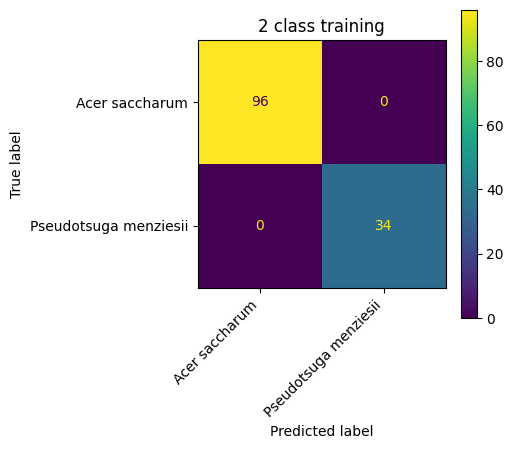

balanced_accuracy_score 0.6536764705882353


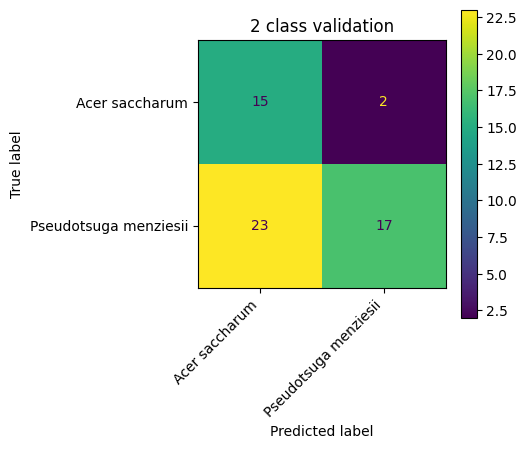

balanced_accuracy_score 1.0


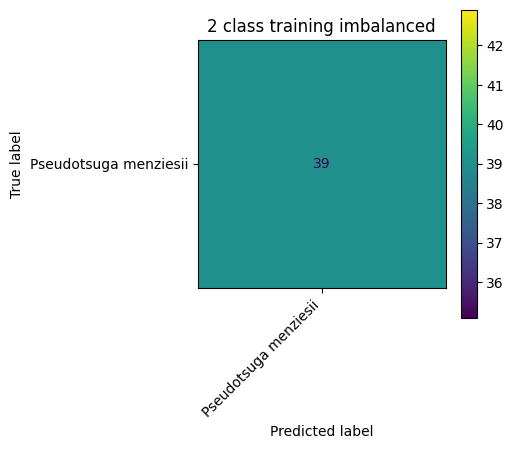

balanced_accuracy_score 1.0


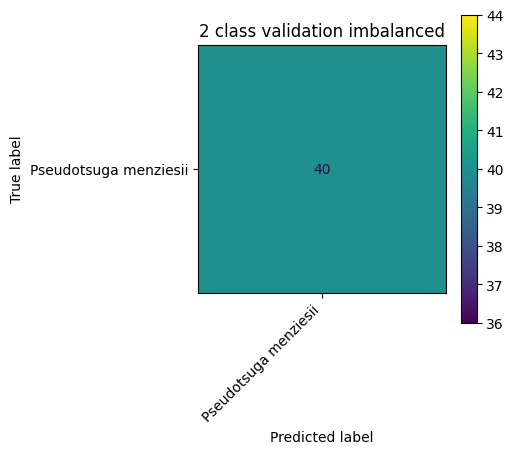

balanced_accuracy_score 0.9142938962526591


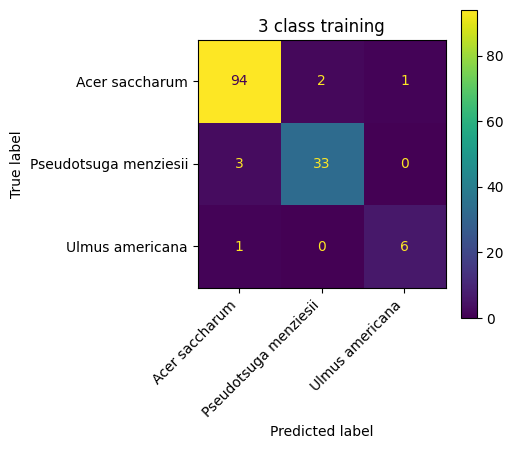

balanced_accuracy_score 0.23970588235294119


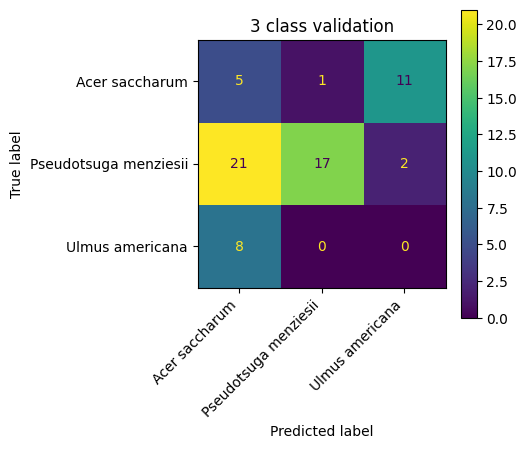

balanced_accuracy_score 0.778631883340863


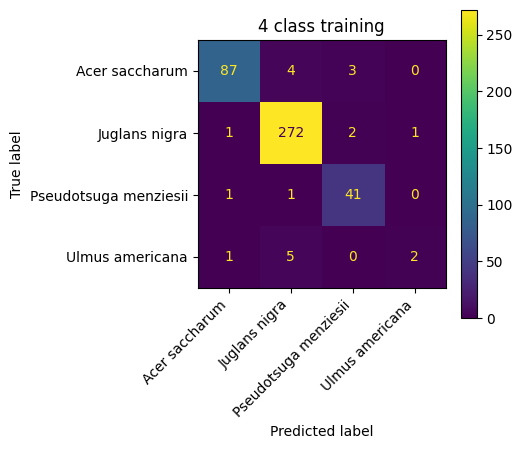

balanced_accuracy_score 0.014705882352941176


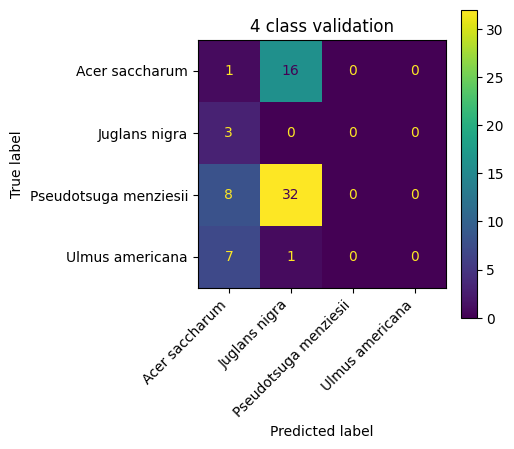

balanced_accuracy_score 0.5224316673470728


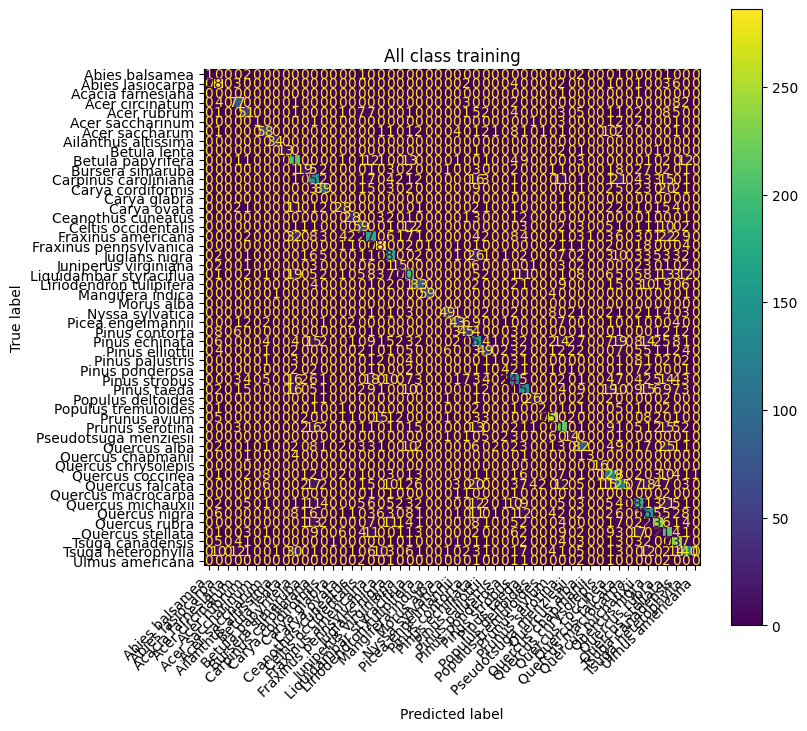

balanced_accuracy_score 0.012878787878787878


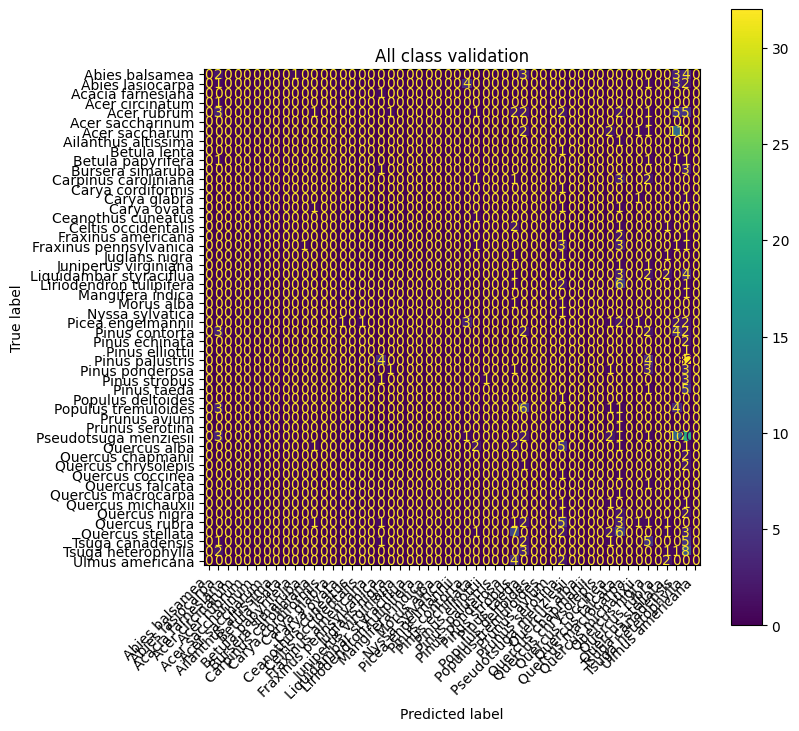

In [30]:
bands = [1, 2, 3, 4, 5, 6, 7, 8]
training_cols = [f'band_{i}' for i in bands] + ['nitian', 'ndvi', 'sr', 'tvi', 'gi', 'gndvi', 'pri', 'osavi', 'tcari', 'redge', 'redge2',
            'siredge', 'normg', 'schl', 'schlcar']

# Run our tests! 
# ---------- 2 class problem with the largest classes in validation
test_species = sp_2
training_df = train_df[train_df.species.isin(test_species)]
valid_df = neon_gold_df[neon_gold_df.species.isin(test_species)]
clf = classify(training_df, training_cols, label='2 class training')
clf = classify(valid_df, training_cols, clf=clf, label='2 class validation')

# ---------- 2 class problem with imbalance
test_species = sp_2_imb
training_df = train_df[train_df.species.isin(test_species)]
valid_df = neon_gold_df[neon_gold_df.species.isin(test_species)]
clf = classify(training_df, training_cols, label='2 class training imbalanced')
clf = classify(valid_df, training_cols, clf=clf, label='2 class validation imbalanced')

# ---------- 3 class problem
test_species = sp_3
training_df = train_df[train_df.species.isin(test_species)]
valid_df = neon_gold_df[neon_gold_df.species.isin(test_species)]
clf = classify(training_df, training_cols, label='3 class training')
clf = classify(valid_df, training_cols, clf=clf, label='3 class validation')

# ---------- 4 class problem
test_species = sp_4
training_df = train_df[train_df.species.isin(test_species)]
valid_df = neon_gold_df[neon_gold_df.species.isin(test_species)]
clf = classify(training_df, training_cols, label='4 class training')
clf = classify(valid_df, training_cols, clf=clf, label='4 class validation')

plt.rcParams["figure.figsize"] = (8,8)

# ---------- All
training_df = train_df.copy() #[train_df.species.isin(test_species)]
valid_df = neon_gold_df.copy() #[neon_gold_df.species.isin(test_species)]
clf = classify(training_df, training_cols, label='All class training')
clf = classify(valid_df, training_cols, clf=clf, label='All class validation')



balanced_accuracy_score 1.0


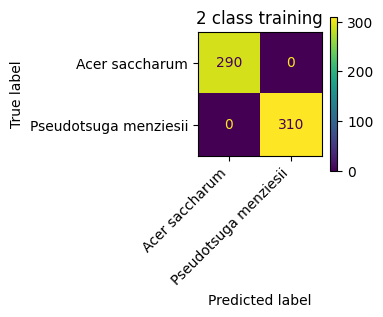

balanced_accuracy_score 0.20599634786578408


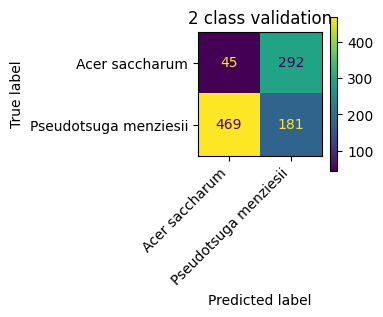

balanced_accuracy_score 1.0


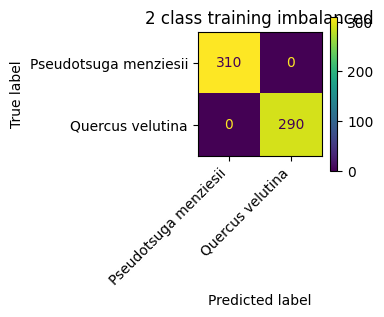

balanced_accuracy_score 0.2453846153846154


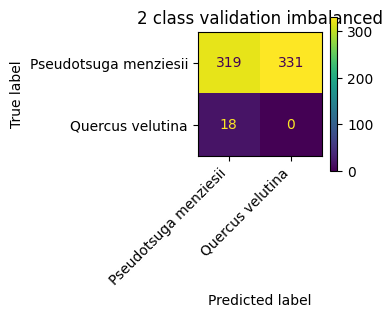

balanced_accuracy_score 0.9738150599898621


/Users/ariane/opt/miniconda3/envs/rhm/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


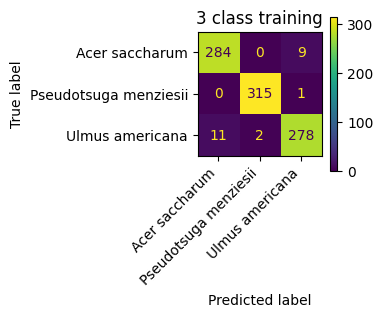

balanced_accuracy_score 0.10262133256585586


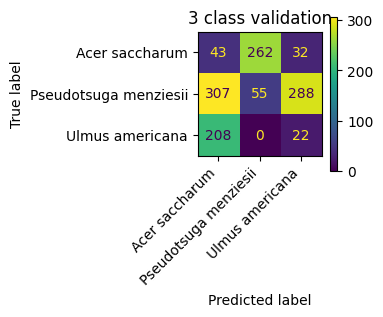

balanced_accuracy_score 0.9260922985060916


/Users/ariane/opt/miniconda3/envs/rhm/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


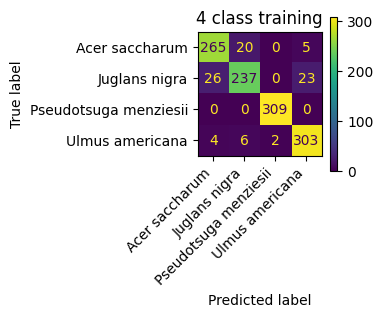

balanced_accuracy_score 0.09807948114507001


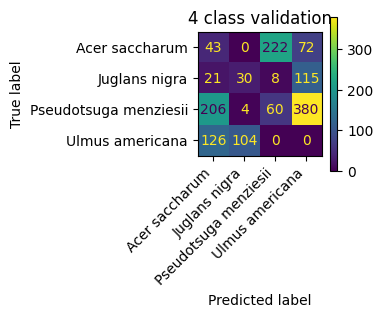

/Users/ariane/opt/miniconda3/envs/rhm/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


balanced_accuracy_score 0.8401996295947818


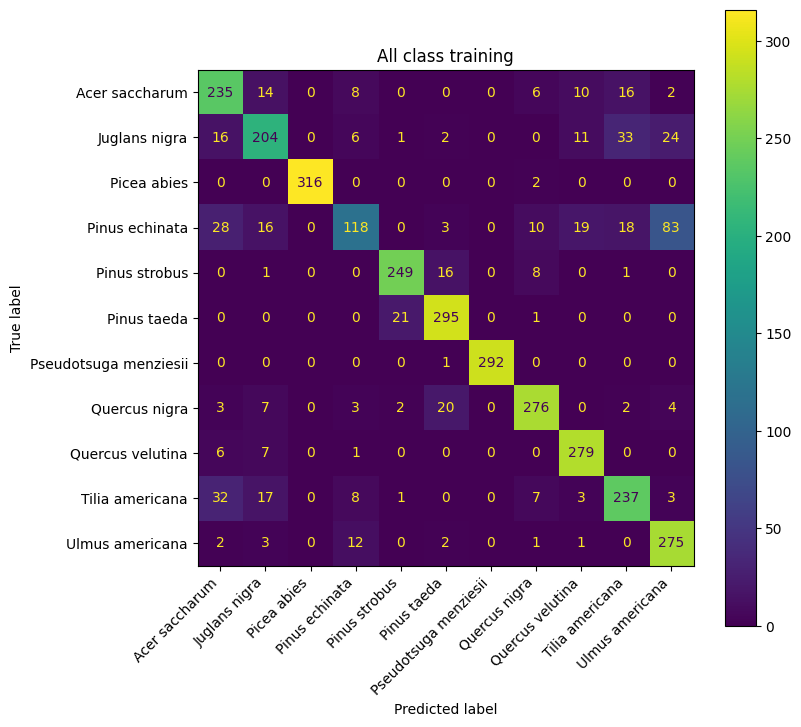

balanced_accuracy_score 0.0156759099785806


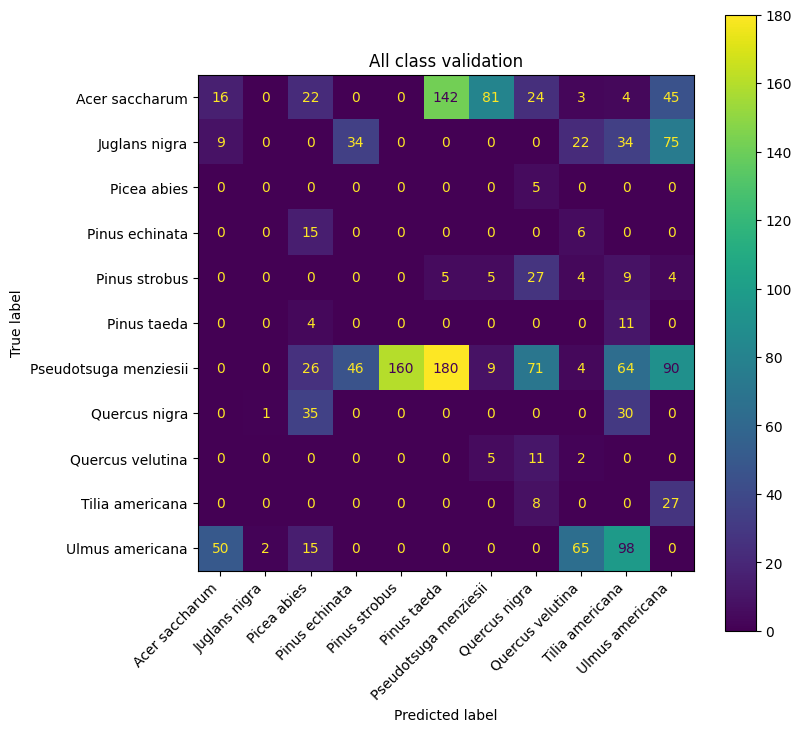

In [14]:
bands = [1, 2, 3, 4, 5, 6, 7, 8]
plt.rcParams["figure.figsize"] = (2,2)
training_cols = [f'band_{i}' for i in bands] + ['nitian', 'ndvi', 'sr', 'tvi', 'gi', 'gndvi', 'pri', 'osavi', 'tcari', 'redge', 'redge2',
            'siredge', 'normg', 'schl', 'schlcar']

# Run our tests! 
# ---------- 2 class problem with the largest classes in validation
test_species = sp_2
training_df = train_df[train_df.species.isin(test_species)]
valid_df = neon_gold_df[neon_gold_df.species.isin(test_species)]
clf = classify(training_df, training_cols, label='2 class training', clf_type='svm')
clf = classify(valid_df, training_cols, clf=clf, label='2 class validation')

# ---------- 2 class problem with imbalance
test_species = sp_2_imb
training_df = train_df[train_df.species.isin(test_species)]
valid_df = neon_gold_df[neon_gold_df.species.isin(test_species)]
clf = classify(training_df, training_cols, label='2 class training imbalanced', clf_type='svm')
clf = classify(valid_df, training_cols, clf=clf, label='2 class validation imbalanced')

# ---------- 3 class problem
test_species = sp_3
training_df = train_df[train_df.species.isin(test_species)]
valid_df = neon_gold_df[neon_gold_df.species.isin(test_species)]
clf = classify(training_df, training_cols, label='3 class training', clf_type='svm')
clf = classify(valid_df, training_cols, clf=clf, label='3 class validation')

# ---------- 4 class problem
test_species = sp_4
training_df = train_df[train_df.species.isin(test_species)]
valid_df = neon_gold_df[neon_gold_df.species.isin(test_species)]
clf = classify(training_df, training_cols, label='4 class training', clf_type='svm')
clf = classify(valid_df, training_cols, clf=clf, label='4 class validation')

plt.rcParams["figure.figsize"] = (8,8)

# ---------- All
training_df = train_df.copy() #[train_df.species.isin(test_species)]
valid_df = neon_gold_df.copy() #[neon_gold_df.species.isin(test_species)]
clf = classify(training_df, training_cols, label='All class training', clf_type='svm')
clf = classify(valid_df, training_cols, clf=clf, label='All class validation')



Pinus palustris            40
Pseudotsuga menziesii      40
Acer rubrum                25
Quercus stellata           22
Acer saccharum             17
Quercus rubra              16
Tsuga canadensis           15
Populus tremuloides        15
Tsuga heterophylla         15
Metrosideros polymorpha    13
Pinus contorta             13
Abies balsamea             13
Picea engelmannii          13
Liquidambar styraciflua    12
Quercus alba               12
Abies lasiocarpa           11

balanced_accuracy_score 0.8931204926667207


/Users/ariane/opt/miniconda3/envs/rhm/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


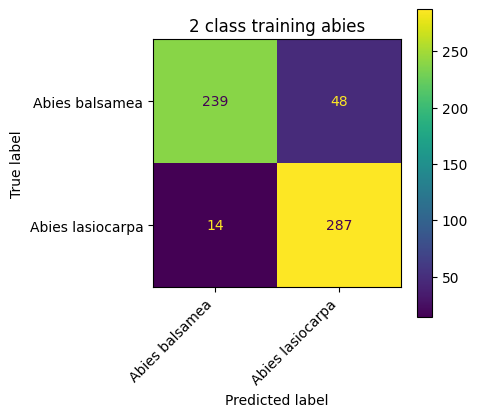

balanced_accuracy_score 0.6958041958041958


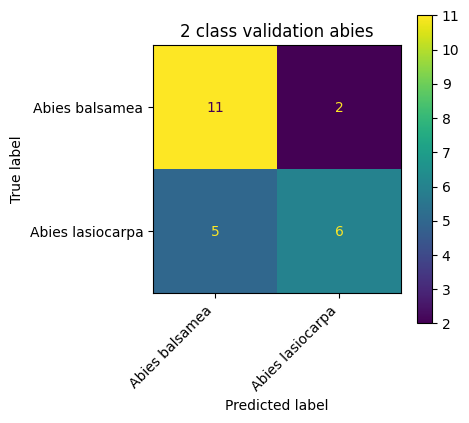

balanced_accuracy_score 0.7878754171301445


/Users/ariane/opt/miniconda3/envs/rhm/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


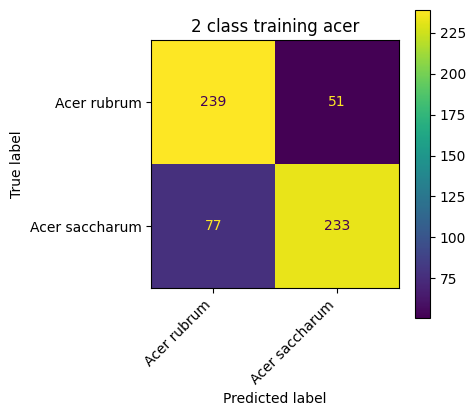

balanced_accuracy_score 0.39294117647058824


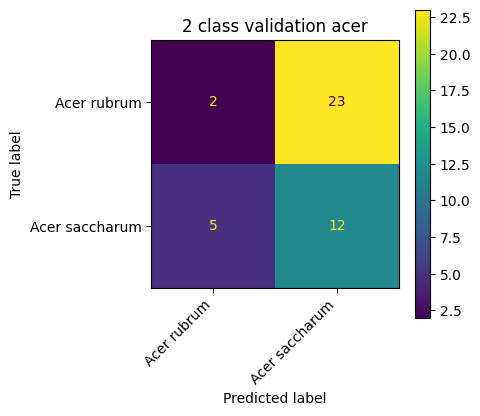

balanced_accuracy_score 0.8267154301637061


/Users/ariane/opt/miniconda3/envs/rhm/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


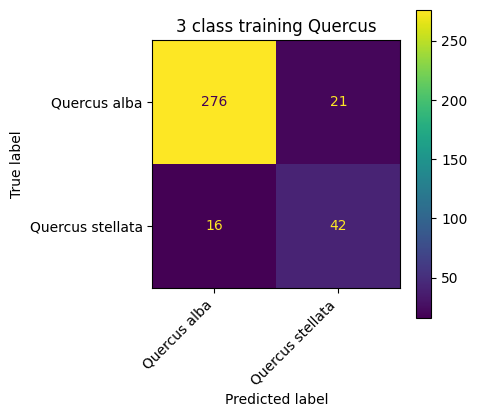

balanced_accuracy_score 0.5189393939393939


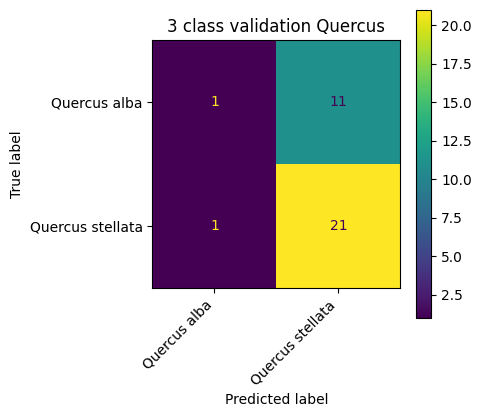

balanced_accuracy_score 0.9899665551839465


/Users/ariane/opt/miniconda3/envs/rhm/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


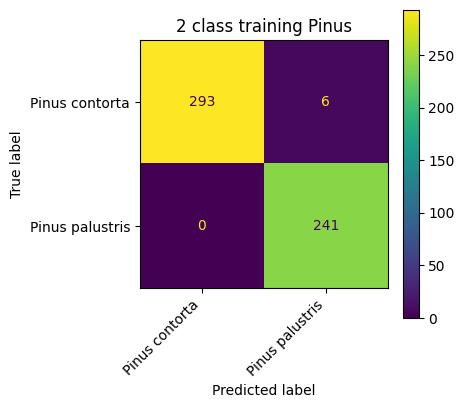

balanced_accuracy_score 0.5490384615384616


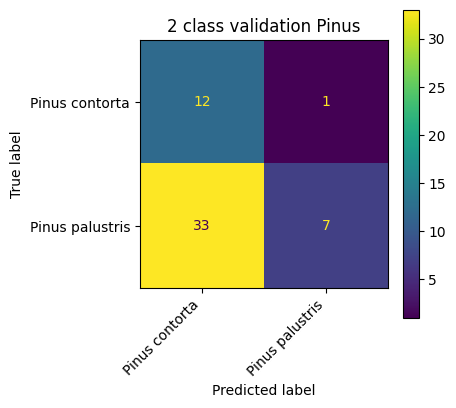

In [38]:
bands = [1, 2, 3, 4, 5, 6, 7, 8]
training_cols = [f'band_{i}' for i in bands] + ['nitian', 'ndvi', 'sr', 'tvi', 'gi', 'gndvi', 'pri', 'osavi', 'tcari', 'redge', 'redge2',
            'siredge', 'normg', 'schl', 'schlcar']

plt.rcParams["figure.figsize"] = (4,4)

# Run our tests! 
# ---------- 2 class problem with the largest classes in validation
test_species = ['Abies lasiocarpa', 'Abies balsamea']
training_df = train_df[train_df.species.isin(test_species)]
valid_df = neon_gold_df[neon_gold_df.species.isin(test_species)]
clf = classify(training_df, training_cols, label='2 class training abies', clf_type='svm')
clf = classify(valid_df, training_cols, clf=clf, label='2 class validation abies')

# ---------- 2 class problem with imbalance
test_species = ['Acer rubrum', 'Acer saccharum']
training_df = train_df[train_df.species.isin(test_species)]
valid_df = neon_gold_df[neon_gold_df.species.isin(test_species)]
clf = classify(training_df, training_cols, label='2 class training acer', clf_type='svm')
clf = classify(valid_df, training_cols, clf=clf, label='2 class validation acer')

# ---------- 3 class problem
test_species = ['Quercus stellata', 'Quercus alba', 'Quercus stellata']
training_df = train_df[train_df.species.isin(test_species)]
valid_df = neon_gold_df[neon_gold_df.species.isin(test_species)]
clf = classify(training_df, training_cols, label='3 class training Quercus', clf_type='svm')
clf = classify(valid_df, training_cols, clf=clf, label='3 class validation Quercus')

# ---------- 2 class problem
test_species = ['Pinus palustris', 'Pinus contorta']
training_df = train_df[train_df.species.isin(test_species)]
valid_df = neon_gold_df[neon_gold_df.species.isin(test_species)]
clf = classify(training_df, training_cols, label='2 class training Pinus', clf_type='svm')
clf = classify(valid_df, training_cols, clf=clf, label='2 class validation Pinus')


balanced_accuracy_score 0.9641439105420955


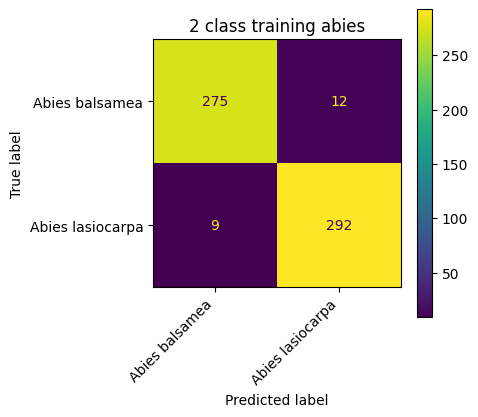

balanced_accuracy_score 0.6433566433566433


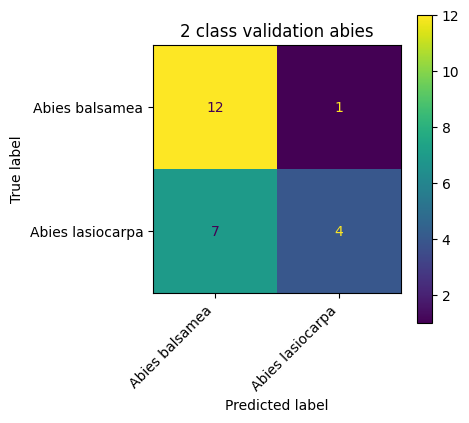

balanced_accuracy_score 0.9078420467185762


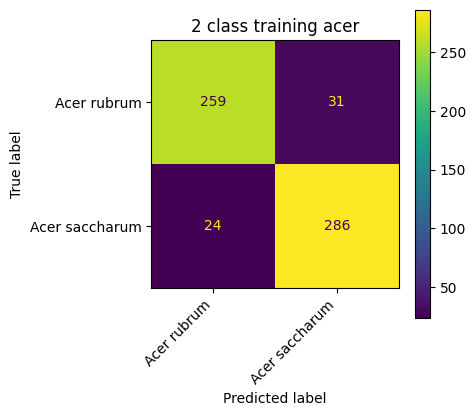

balanced_accuracy_score 0.5


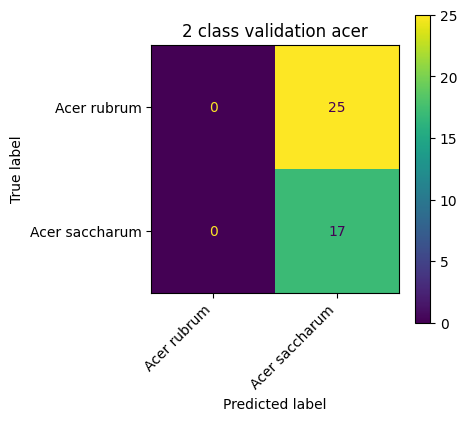

balanced_accuracy_score 0.8069778242192036


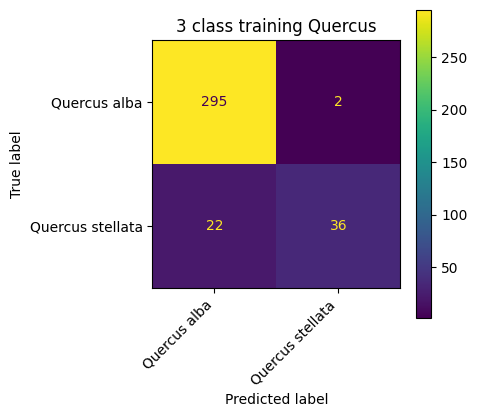

balanced_accuracy_score 0.4962121212121212


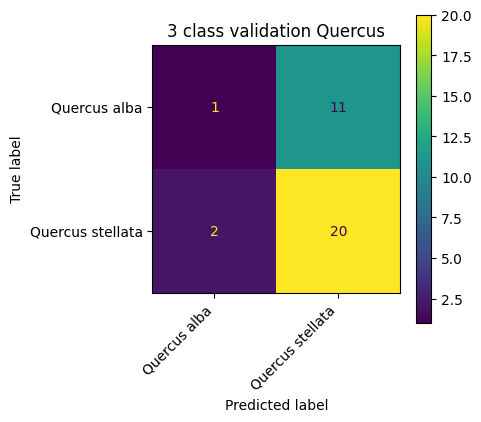

balanced_accuracy_score 0.9962530704006439


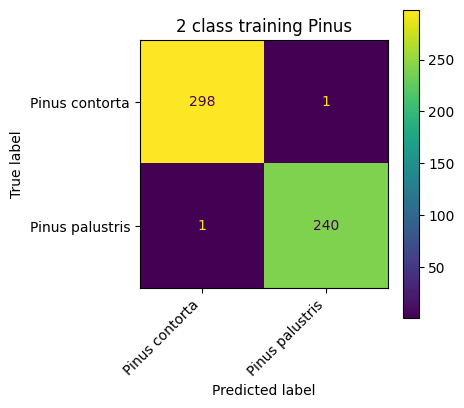

balanced_accuracy_score 0.525


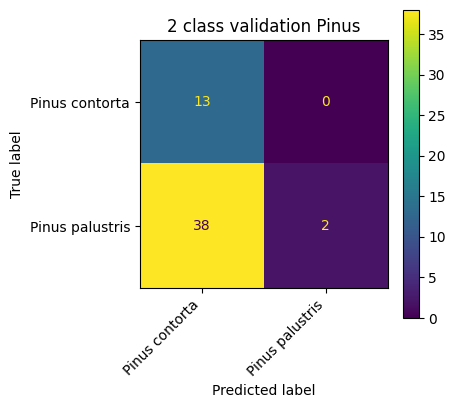

In [39]:
bands = [1, 2, 3, 4, 5, 6, 7, 8]
training_cols = [f'band_{i}' for i in bands] + ['nitian', 'ndvi', 'sr', 'tvi', 'gi', 'gndvi', 'pri', 'osavi', 'tcari', 'redge', 'redge2',
            'siredge', 'normg', 'schl', 'schlcar']

plt.rcParams["figure.figsize"] = (4,4)

# Run our tests! 
# ---------- 2 class problem with the largest classes in validation
test_species = ['Abies lasiocarpa', 'Abies balsamea']
training_df = train_df[train_df.species.isin(test_species)]
valid_df = neon_gold_df[neon_gold_df.species.isin(test_species)]
clf = classify(training_df, training_cols, label='2 class training abies')
clf = classify(valid_df, training_cols, clf=clf, label='2 class validation abies')

# ---------- 2 class problem with imbalance
test_species = ['Acer rubrum', 'Acer saccharum']
training_df = train_df[train_df.species.isin(test_species)]
valid_df = neon_gold_df[neon_gold_df.species.isin(test_species)]
clf = classify(training_df, training_cols, label='2 class training acer')
clf = classify(valid_df, training_cols, clf=clf, label='2 class validation acer')

# ---------- 3 class problem
test_species = ['Quercus stellata', 'Quercus alba', 'Quercus stellata']
training_df = train_df[train_df.species.isin(test_species)]
valid_df = neon_gold_df[neon_gold_df.species.isin(test_species)]
clf = classify(training_df, training_cols, label='3 class training Quercus')
clf = classify(valid_df, training_cols, clf=clf, label='3 class validation Quercus')

# ---------- 2 class problem
test_species = ['Pinus palustris', 'Pinus contorta']
training_df = train_df[train_df.species.isin(test_species)]
valid_df = neon_gold_df[neon_gold_df.species.isin(test_species)]
clf = classify(training_df, training_cols, label='2 class training Pinus')
clf = classify(valid_df, training_cols, clf=clf, label='2 class validation Pinus')
